In [1]:
from pathlib import Path

import numpy as np
import tqdm
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
from edpyt.shared import params
from matplotlib import pyplot as plt

In [2]:
class Sigma:

    def __init__(self, gf0, gf, eta=1e-5):
        self.gf0 = gf0
        self.gf = gf
        self.eta = eta

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g0 = self.gf0(energies, self.eta)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,gf.n,gf.n), complex)
        for e, energy in enumerate(tqdm.tqdm(energies)):
            sigma[e] = np.linalg.inv(g0[...,e]) - np.linalg.inv(g[...,e])
        return sigma


In [3]:
path = Path('../output/lowdin/')
H_eff = np.load(path/'effective_hamiltonian.npy')
nimp = H_eff.shape[0]
occupancy_goal = np.load("../output/lowdin/occupancy/occupancies_gfp.npy")
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
eta = 6e-2
z = energies + eta*1.j
beta = 1000.
# beta = 70.
params['z'] = occupancy_goal
V = np.loadtxt('../output/lowdin/U_matrix.txt')
DC = np.diag(V.diagonal()*(occupancy_goal-0.5))
# neig = get_active_neig(nimp, [(nimp//2,nimp//2)], 3)
neig = np.ones((nimp+1)*(nimp+1),int) * 4

In [4]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)
# TODO Look at implementing build_gf_lanczos here instead of build_gf2_lanczos
DOS0 = -1/np.pi * gf0(energies, eta).imag.trace(axis1=0,axis2=1)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


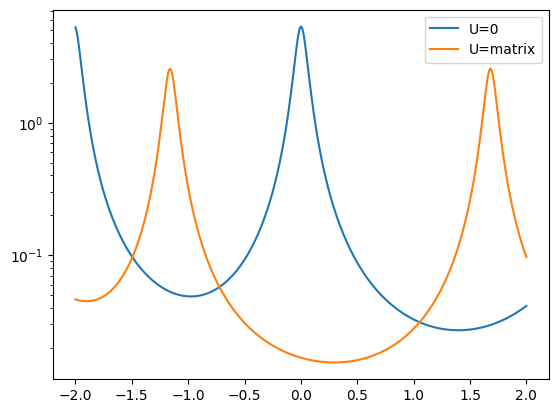

In [5]:
espace, egs = build_espace(H_eff-DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff-DC, V, espace, beta, egs)
DOS = -1/np.pi * gf(energies, eta).imag.trace(axis1=0,axis2=1)

plt.plot(energies, DOS0, label="U=0")
plt.plot(energies, DOS, label="U=matrix")
plt.legend()
plt.yscale('log')
plt.show()

In [6]:
sigma = Sigma(gf0, gf, eta=eta)
sig = sigma.retarded(energies)
np.save('../output/lowdin/ed/ed_sigma.npy', sig)
sig_trace = np.trace(sig,axis1=1,axis2=2)

100%|██████████| 401/401 [00:00<00:00, 8345.07it/s]


In [7]:
ref_sig_uii_trace = np.loadtxt('../reference/sigma_ed_uii_trace.txt')
ref_sig_ed_trace = np.loadtxt('../reference/sigma_ed_trace.txt')
ref_sig_uii_diag = np.loadtxt('../reference/sigma_ed_uii_diag.txt')
ref_sig_ed_diag = np.loadtxt('../reference/sigma_ed_diag.txt')


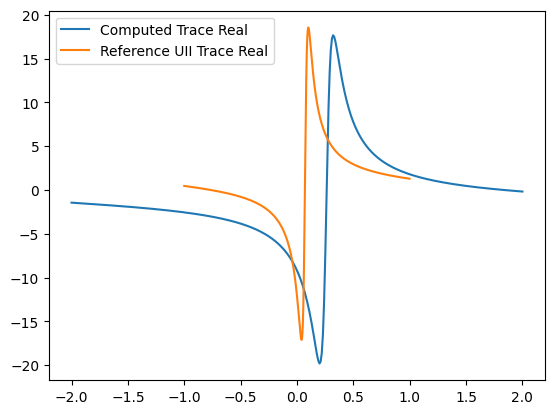

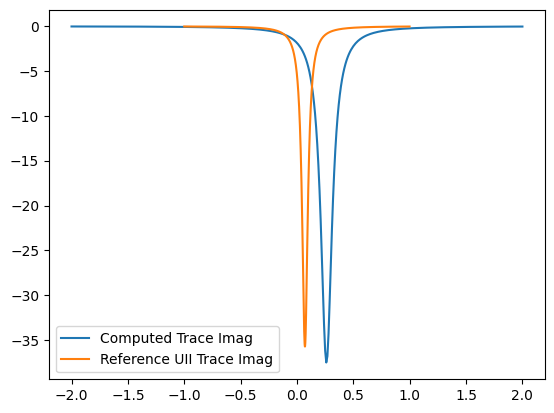

In [8]:
# Plot the real part of the trace
plt.plot(energies, sig_trace.real, label="Computed Trace Real")
plt.plot(ref_sig_uii_trace[:, 0], ref_sig_uii_trace[:, 1], label="Reference UII Trace Real")
# plt.plot(ref_sig_ed_trace[:, 0], ref_sig_ed_trace[:, 1], label="Reference ED Trace Real")
plt.legend()
plt.show()

# Plot the imaginary part of the trace
plt.plot(energies, sig_trace.imag, label="Computed Trace Imag")
plt.plot(ref_sig_uii_trace[:, 0], ref_sig_uii_trace[:, 2], label="Reference UII Trace Imag")
# # plt.plot(ref_sig_ed_trace[:, 0], ref_sig_ed_trace[:, 2], label="Reference ED Trace Imag")
plt.legend()
plt.show()